# Анализ покупательской активности и построение модели прогноза снижения активности клиентов

<b>
Цель проекта:<br><br>
Разработать модель машинного обучения для прогнозирования изменения покупательской активности клиентов интернет-магазина и провести сегментацию клиентов на основе вероятности их "оттока" (снижения активности), чтобы выработать рекомендации по удержанию клиентов и увеличению их лояльности.<br><br>
План выполнения проекта:<br><br>
1. Сбор и подготовка данных: создание и первичный анализ четырех датафреймов<br>
2. Предобработка данных: удаление дубликатов, пустых значений, проверка типов данных.<br>
3. Исследовательский анализ: посмотреть распределения данных и убрать выбросы, если это потребуется.<br>
4. Объединение таблиц: создание из трех датафреймов одного целого, чтобы в дальнейшем использовать эти данные в модели<br>
5. Корреляционный анализ: посмотреть корреляцию признаков, убрать мультиколлинеарность, если она присутствует<br>
6. Создание пайплайнов: созданире пайплайнов для теста сразу нескольких моделей с разными параметрами, чтобы отобрать лучшую из них<br>
7. Анализ важности признаков: создать график при помощи shap и оценить важность каждого признака.<br>
8. Сегментация покупателей: сегментация покупателей на 3 класса - низкий, средний, высокий риск "оттока"<br>
9. Общий вывод.
</b>

# Импорт библиотек

In [1]:
!pip install phik -q
!pip install shap -q

In [2]:
import time
# Библиотеки для работы с данными
import numpy as np
import pandas as pd
import re

# Библиотеки для визуализации
import matplotlib.pyplot as plt
import seaborn as sns
from phik import phik_matrix
import shap

# Библиотеки для создания модели
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import (StandardScaler, 
                                   MinMaxScaler, 
                                   OneHotEncoder, 
                                   OrdinalEncoder, 
                                   LabelEncoder)
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import (make_scorer, 
                             roc_auc_score, 
                             f1_score, 
                             accuracy_score)

## 1. Загрузка данных

<b>1.1 Создание датафреймов</b>

In [3]:
# Данные о поведении покупателя на сайте
market_file_df = pd.read_csv('/datasets/market_file.csv', delimiter=',')
# Данные о выручке
market_money_df = pd.read_csv('/datasets/market_money.csv', delimiter=',')
# Данные о времени
market_time_df = pd.read_csv('/datasets/market_time.csv', delimiter=',')
# Данные о среднемесячной прибыли продавца за последние 3 месяца
money_df = pd.read_csv('/datasets/money.csv', delimiter=';', decimal=',')

<b>1.2 Создание функции для первичного анализа</b>

In [4]:
def primary_analysis(df):
    display(df.head(20))
    df.info()
    display(df.describe())
    return ''

<b>1.3 Первичный анализ</b>

In [5]:
print('Данные о поведении покупателя на сайте')
print(primary_analysis(market_file_df), '\n', market_file_df.shape)
print('Данные о выручке')
print(primary_analysis(market_money_df), '\n', market_money_df.shape)
print('Данные о времени')
print(primary_analysis(market_time_df), '\n', market_time_df.shape)
print('Данные о среднемесячной прибыли продавца за последние 3 месяца')
print(primary_analysis(money_df), '\n', money_df.shape)

Данные о поведении покупателя на сайте


,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандартт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандартт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
4,215352,Снизилась,стандартт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2
5,215353,Снизилась,стандартт,да,3.3,4,762,0.26,Домашний текстиль,4,1,1,4
6,215354,Снизилась,стандартт,да,5.1,3,431,0.23,Косметика и аксесуары,2,3,7,2
7,215355,Снизилась,стандартт,нет,4.7,4,284,0.17,Товары для детей,5,1,6,4
8,215356,Снизилась,стандартт,да,4.2,4,192,0.14,Косметика и аксесуары,2,2,1,3
9,215357,Снизилась,стандартт,да,3.9,5,154,0.00,Техника для красоты и здоровья,3,3,9,5


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   Покупательская активность            1300 non-null   object 
 2   Тип сервиса                          1300 non-null   object 
 3   Разрешить сообщать                   1300 non-null   object 
 4   Маркет_актив_6_мес                   1300 non-null   float64
 5   Маркет_актив_тек_мес                 1300 non-null   int64  
 6   Длительность                         1300 non-null   int64  
 7   Акционные_покупки                    1300 non-null   float64
 8   Популярная_категория                 1300 non-null   object 
 9   Средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  Неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  Ошибка_сервиса                

,id,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
count,1300.000000,1300.000000,1300.000000,1300.000000,1300.000000,1300.00000,1300.000000,1300.000000,1300.000000
mean,215997.500000,4.253769,4.011538,601.898462,0.319808,3.27000,2.840000,4.185385,8.176923
std,375.421985,1.014814,0.696868,249.856289,0.249843,1.35535,1.971451,1.955298,3.978126
min,215348.000000,0.900000,3.000000,110.000000,0.000000,1.00000,0.000000,0.000000,1.000000
25%,215672.750000,3.700000,4.000000,405.500000,0.170000,2.00000,1.000000,3.000000,5.000000
50%,215997.500000,4.200000,4.000000,606.000000,0.240000,3.00000,3.000000,4.000000,8.000000
75%,216322.250000,4.900000,4.000000,806.000000,0.300000,4.00000,4.000000,6.000000,11.000000
max,216647.000000,6.600000,5.000000,1079.000000,0.990000,6.00000,10.000000,9.000000,20.000000


 
 (1300, 13)
Данные о выручке


,id,Период,Выручка
0,215348,препредыдущий_месяц,0.0
1,215348,текущий_месяц,3293.1
2,215348,предыдущий_месяц,0.0
3,215349,препредыдущий_месяц,4472.0
4,215349,текущий_месяц,4971.6
5,215349,предыдущий_месяц,5216.0
6,215350,препредыдущий_месяц,4826.0
7,215350,текущий_месяц,5058.4
8,215350,предыдущий_месяц,5457.5
9,215351,текущий_месяц,6610.4


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3900 non-null   int64  
 1   Период   3900 non-null   object 
 2   Выручка  3900 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 91.5+ KB


,id,Выручка
count,3900.000000,3900.000000
mean,215997.500000,5025.696051
std,375.325686,1777.704104
min,215348.000000,0.000000
25%,215672.750000,4590.150000
50%,215997.500000,4957.500000
75%,216322.250000,5363.000000
max,216647.000000,106862.200000


 
 (3900, 3)
Данные о времени


,id,Период,минут
0,215348,текущий_месяц,14
1,215348,предыдцщий_месяц,13
2,215349,текущий_месяц,10
3,215349,предыдцщий_месяц,12
4,215350,текущий_месяц,13
5,215350,предыдцщий_месяц,8
6,215351,текущий_месяц,13
7,215351,предыдцщий_месяц,11
8,215352,текущий_месяц,11
9,215352,предыдцщий_месяц,8


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2600 non-null   int64 
 1   Период  2600 non-null   object
 2   минут   2600 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.1+ KB


,id,минут
count,2600.000000,2600.000000
mean,215997.500000,13.336154
std,375.349754,4.080198
min,215348.000000,4.000000
25%,215672.750000,10.000000
50%,215997.500000,13.000000
75%,216322.250000,16.000000
max,216647.000000,23.000000


 
 (2600, 3)
Данные о среднемесячной прибыли продавца за последние 3 месяца


,id,Прибыль
0,215348,0.98
1,215349,4.16
2,215350,3.13
3,215351,4.87
4,215352,4.21
5,215353,3.95
6,215354,3.62
7,215355,5.26
8,215356,4.93
9,215357,4.66


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       1300 non-null   int64  
 1   Прибыль  1300 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 20.4 KB


,id,Прибыль
count,1300.000000,1300.000000
mean,215997.500000,3.996631
std,375.421985,1.013722
min,215348.000000,0.860000
25%,215672.750000,3.300000
50%,215997.500000,4.045000
75%,216322.250000,4.670000
max,216647.000000,7.430000


 
 (1300, 2)


<b>1.4 Вывод по первичному анализу</b>

<b>Сразу можно увидить неявные дубликаты в таблице market_file_df. Также видим опечатки в столбцах (в столбце 'Период' таблицы market_time_df это некритично, но все же, мы это исправим). Пропуски в таблицах отсутствуют</b>

## 2. Предобработка данных

<b>2.1 Поиск неявных дубликатов</b>

In [6]:
market_file_df['Тип сервиса'].value_counts()

стандарт     914
премиум      376
стандартт     10
Name: Тип сервиса, dtype: int64

<b>Есть неявные дубликаты из-за опечатки</b>

In [7]:
market_file_df['Тип сервиса'] = market_file_df['Тип сервиса'].replace('стандартт', 'стандарт')
market_file_df['Тип сервиса'].value_counts()

стандарт    924
премиум     376
Name: Тип сервиса, dtype: int64

In [8]:
market_time_df['Период'].value_counts()

предыдцщий_месяц    1300
текущий_месяц       1300
Name: Период, dtype: int64

<b>Исправим опечатку (необязательно)</b>

In [9]:
market_time_df['Период'] = market_time_df['Период'].replace('предыдцщий_месяц', 'предыдущий_месяц')
market_time_df['Период'].value_counts()

текущий_месяц       1300
предыдущий_месяц    1300
Name: Период, dtype: int64

<b>2.2 Поиск и удаление явных дубликатов</b>

In [10]:
# Функция для поиска и удаления явных дубликатов
def search_duplicated(df):
    print(df.duplicated().sum())
    if df.duplicated().sum() > 0:
        df.drop_duplicates(inplace=True)
        print('Дубликаты удалены')
    return

In [11]:
search_duplicated(market_file_df)
search_duplicated(market_money_df)
search_duplicated(market_time_df)
search_duplicated(money_df)

0
0
0
0


<b>Явные дубликаты не найдены</b>

<b>2.3 Проверка на пустые значения в таблицах</b>

In [12]:
print(market_file_df.isnull().sum().sum())
print(market_money_df.isnull().sum().sum())
print(market_time_df.isnull().sum().sum())
print(money_df.isnull().sum().sum())

0
0
0
0


<b>Ранее уже было сказано, что пустых значений нет, но все же нужно было перестраховаться</b>

<b>2.4 Проверка типов данных</b>

In [13]:
print(market_file_df.dtypes)
print(market_money_df.dtypes)
print(market_time_df.dtypes)
print(money_df.dtypes)


id                                       int64
Покупательская активность               object
Тип сервиса                             object
Разрешить сообщать                      object
Маркет_актив_6_мес                     float64
Маркет_актив_тек_мес                     int64
Длительность                             int64
Акционные_покупки                      float64
Популярная_категория                    object
Средний_просмотр_категорий_за_визит      int64
Неоплаченные_продукты_штук_квартал       int64
Ошибка_сервиса                           int64
Страниц_за_визит                         int64
dtype: object
id           int64
Период      object
Выручка    float64
dtype: object
id         int64
Период    object
минут      int64
dtype: object
id           int64
Прибыль    float64
dtype: object


<b>Проблем с типами данных нет</b>

<b>2.5 Приведение столбцов к 'змеиному' виду</b>

In [14]:
def snake_columns(col):
    '''
    Функция для приведения столбцов к змеиному виду
    '''
    col = col.strip()   # Для начала убираем пробелы
    col = col.lower()   # Приведем название к нижнему регистру
    col = re.sub(r'[^\w\s]', '', col)   # Убираем символы
    col = re.sub(r'\s+', '_', col)   # Пробелы заменяем на подчеркивания
    
    return col


# Создание списка датафреймов для одновременной обработки
dfs = [market_file_df, market_money_df, market_time_df, money_df]

In [15]:
# Обработка всех датафреймов
for i, df in enumerate(dfs):
    df.columns = [snake_columns(col) for col in df.columns]
    print(f"Новые имена колонок:\n{df.columns}\n")

Новые имена колонок:
Index(['id', 'покупательская_активность', 'тип_сервиса', 'разрешить_сообщать',
       'маркет_актив_6_мес', 'маркет_актив_тек_мес', 'длительность',
       'акционные_покупки', 'популярная_категория',
       'средний_просмотр_категорий_за_визит',
       'неоплаченные_продукты_штук_квартал', 'ошибка_сервиса',
       'страниц_за_визит'],
      dtype='object')

Новые имена колонок:
Index(['id', 'период', 'выручка'], dtype='object')

Новые имена колонок:
Index(['id', 'период', 'минут'], dtype='object')

Новые имена колонок:
Index(['id', 'прибыль'], dtype='object')



<b>2.6 Итог предобработки данных</b>

<b>Мы выявили неявные дубликаты из-за опечатки в таблице market_file_df в столбце 'Тип сервиса', затем исправили опечатку. Также была исправлена опечатка в таблице market_time_df в столбце 'Период'. Эта опечатка некритична, так как из-за нее не образуются дубликаты, но все же для удобства она была исправлена. Пропущенных значений и явных дубликатов не обнаружено. Типы данных соответствуют своим значениям. Названия столбцов были приведены к 'змеиному' виду</b>

## 3. Исследовательский анализ данных

<b>3.1 Анализ распределения данных</b>

In [16]:
discrete_cols = ['маркет_актив_тек_мес', 'средний_просмотр_категорий_за_визит',
                 'неоплаченные_продукты_штук_квартал', 'ошибка_сервиса']

continuous_cols = ['маркет_актив_6_мес', 'длительность', 'акционные_покупки', 'страниц_за_визит']

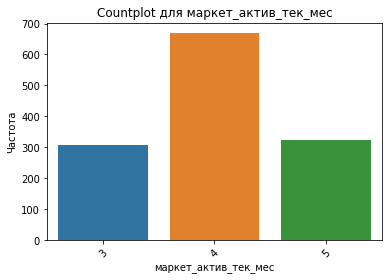

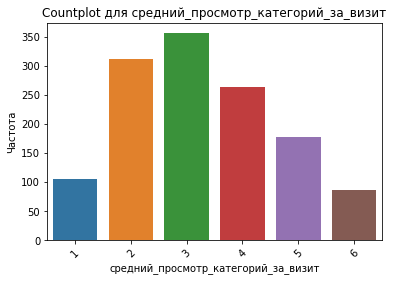

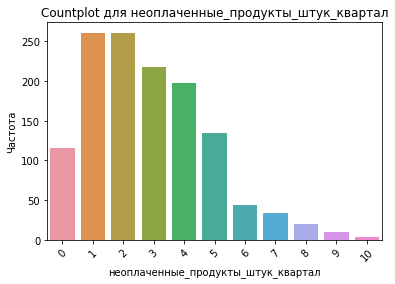

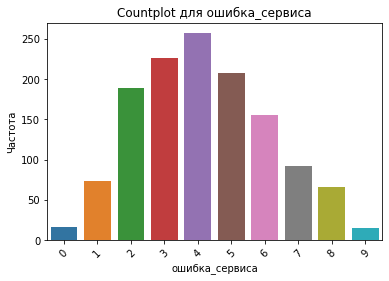

In [17]:
# Дискретные переменные - countplot
for col in discrete_cols:
    plt.figure(figsize=(6, 4))
    sns.countplot(x=market_file_df[col])
    plt.title(f'Countplot для {col}')
    plt.xlabel(col)
    plt.ylabel('Частота')
    plt.xticks(rotation=45)
    plt.show()

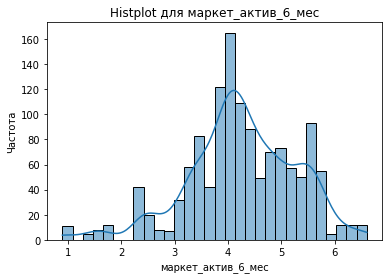

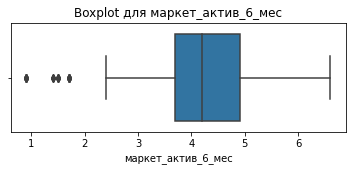

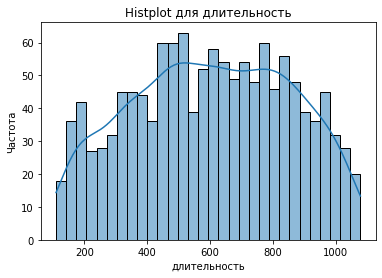

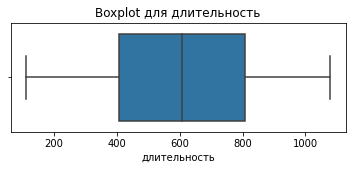

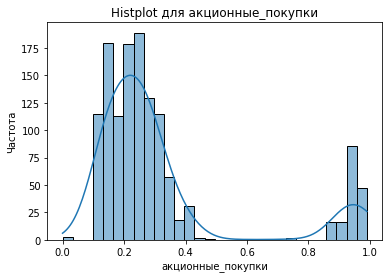

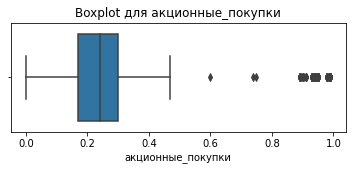

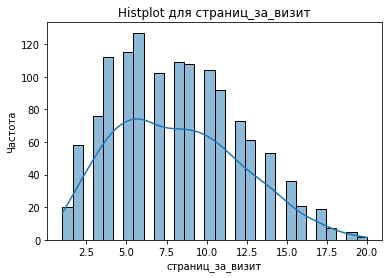

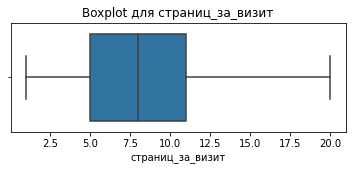

In [18]:
# Непрерывные переменные - histplot + boxplot
for col in continuous_cols:
    plt.figure(figsize=(6, 4))
    sns.histplot(market_file_df[col], bins=30, kde=True)
    plt.title(f'Histplot для {col}')
    plt.xlabel(col)
    plt.ylabel('Частота')
    plt.show()

    plt.figure(figsize=(6, 2))
    sns.boxplot(x=market_file_df[col])
    plt.title(f'Boxplot для {col}')
    plt.xlabel(col)
    plt.show()

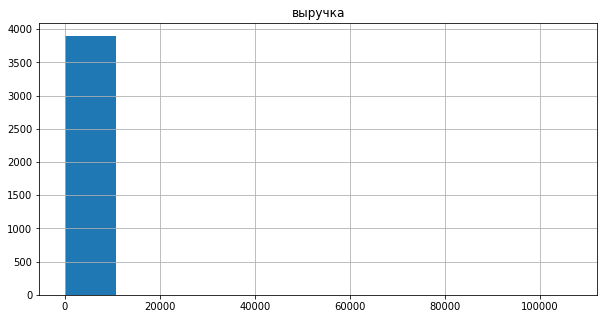

In [19]:
market_money_df.drop(columns='id', axis=1).hist(figsize=(10, 5));

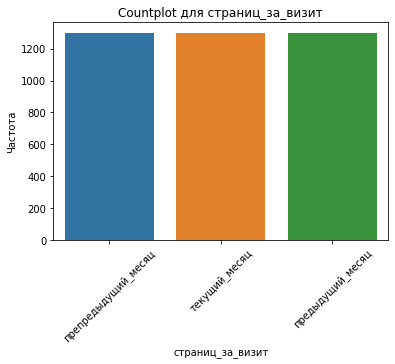

In [20]:
plt.figure(figsize=(6, 4))
sns.countplot(x=market_money_df['период'])
plt.title(f'Countplot для {col}')
plt.xlabel(col)
plt.ylabel('Частота')
plt.xticks(rotation=45)
plt.show()

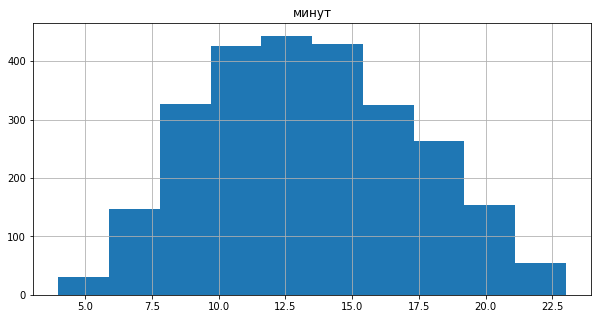

In [21]:
market_time_df.drop(columns='id', axis=1).hist(figsize=(10, 5));

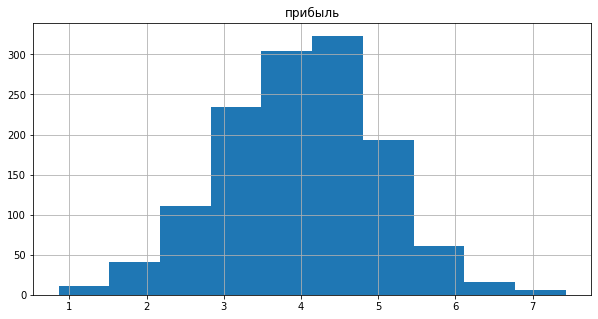

In [22]:
money_df.drop(columns='id', axis=1).hist(figsize=(10, 5));

<b>Видим, что в столбце 'Выручка' есть выброс, который мешает посмотреть распределение</b>

In [23]:
market_money_df['выручка'].sort_values(ascending=False)

98      106862.2
435       7799.4
262       7605.3
1481      7557.0
2388      7547.8
          ...   
34           0.0
29           0.0
28           0.0
2            0.0
0            0.0
Name: выручка, Length: 3900, dtype: float64

<b>Также можем увидить нулевые значения, которые также помешают посмотреть на распределение</b>

array([[<AxesSubplot:title={'center':'выручка'}>]], dtype=object)

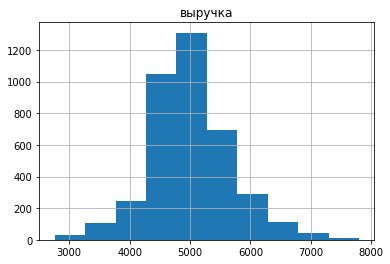

In [24]:
market_money_df.query('выручка < 106862 & выручка > 0').drop(columns='id', axis=1).hist()

<b>Чтобы выбросы не искажали значение метрики при создании модели, мы уберем их из таблицы</b>

In [25]:
market_money_df = market_money_df.query('выручка < 106862 & выручка > 0')

In [26]:
market_money_df.shape

(3893, 3)

<b>Всего было удалено 7 строк</b>

<b>3.2 Анализ категориальных признаков</b>

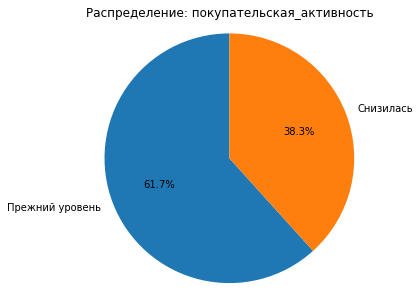

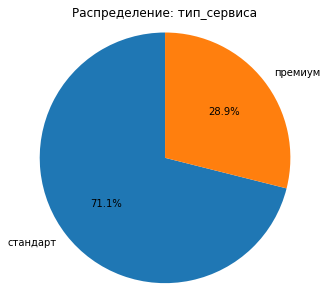

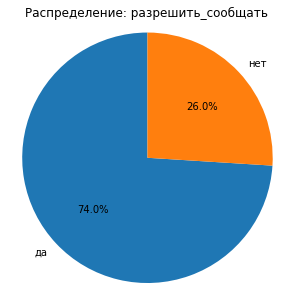

In [27]:
cat_columns = ['покупательская_активность', 'тип_сервиса', 'разрешить_сообщать']

for col in cat_columns:
    counts = market_file_df[col].value_counts()
    num_unique = counts.shape[0]

    plt.figure(figsize=(5, 5))
    plt.pie(counts, labels=counts.index, autopct='%1.1f%%', startangle=90)
    plt.title(f"Распределение: {col}")
    plt.axis('equal')

<b>Можем заметить, что в столбце 'Покупательская активность' дисбаланс классов, поэтому для создания моделей мы не сможем использовать метрику accuracy, нам больше подойдет roc-auc.</b>

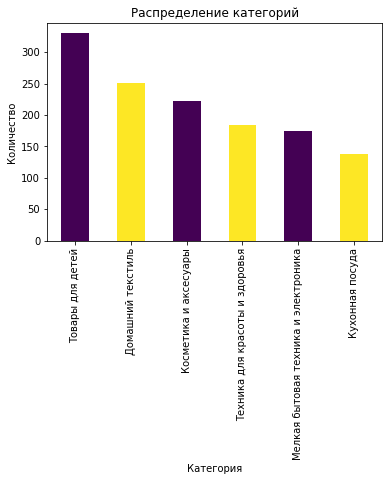

In [28]:
colors = plt.cm.viridis(np.linspace(0, 1, len(counts)))
counts  = market_file_df['популярная_категория'].value_counts()

counts.plot(kind='bar', color=colors)
plt.title('Распределение категорий')
plt.xlabel('Категория')
plt.ylabel('Количество')
plt.show();

<b>Самая популярная категория - товары для детей. Кухонная посуда пользуется наименьшей популярностью</b>

<b>3.3 Анализ активных клиентов</b>

<b>Для удобства сделаем сводную таблицу (также эта сводная таблица понадобится для создания общего датафрейма)</b>

In [29]:
pivot_df_market_money = market_money_df.pivot(index='id', columns='период', values='выручка').reset_index()
pivot_df_market_money.head(10)

период,id,предыдущий_месяц,препредыдущий_месяц,текущий_месяц
0,215348,NaN,NaN,3293.1
1,215349,5216.0,4472.0,4971.6
2,215350,5457.5,4826.0,5058.4
3,215351,6158.0,4793.0,6610.4
4,215352,5807.5,4594.0,5872.5
5,215353,4738.5,5124.0,5388.5
6,215354,5685.0,4503.0,5869.6
7,215355,3263.0,4749.0,3772.6
8,215356,4146.5,4433.0,4566.4
9,215357,NaN,NaN,5986.3


<b>После удаления выбросов остались строки с пустыми значениями (из-за создание сводной таблицы). Нужно от них избавиться</b>

In [30]:
pivot_df_market_money = pivot_df_market_money.dropna()
pivot_df_market_money.shape

(1296, 4)

<b>Для того чтобы отобрать из сводной таблицы подходячих клиентов, нужно просто перемножить столбцы (Если есть хотя бы одно нулевое значение, произведение столбцов выдаст 0)</b>

In [31]:
active_clients = pivot_df_market_money.query('препредыдущий_месяц * предыдущий_месяц * текущий_месяц > 0')

In [32]:
active_clients.shape

(1296, 4)

<b>По заданным критериям подходят все строки сводной таблицы. Это связано с тем, что ранее были удалены выбросы, поэтому для объединения таблиц можно будет использовать сводную таблицу, которую мы сделали ранее</b>

<b>3.4 Итог анализа датафреймов</b>

<b>Самое важное, мы удалили выбросы из таблицы market_money_df, а также пустые значения из сводной таблицы, которые появились из-за удаления выбросов. Размереность датафрейма практически не изменилась, так как было удалено всего 4 пользователя. В целевой переменной присутствует дисбаланс классов, что говорит нам о том, что стандартная метрика accuracy не подойдет для оценки качества модели, поэтому мы будем использовать метрику roc-auc. Также можем заметить, что товары для детей являются самыми популярными, а кухонная посуда менее популярна. Пользователей со статусом премиум (28.9%) сильно меньше, чем со статусом стандарт(71.1%).</b>

## 4. Объединение таблиц

<b>4.1 Сделаем сводные таблицы и переименуем столбцы для объеденения в одну таблицу</b>

In [33]:
pivot_market_time_df = market_time_df.pivot(index='id', columns='период', values='минут').reset_index()
pivot_market_time_df = pivot_market_time_df.rename(columns={
    'предыдущий_месяц': 'предыдущий_месяц_время',
    'текущий_месяц': 'текущий_месяц_время'
})
pivot_market_time_df.head(10)

период,id,предыдущий_месяц_время,текущий_месяц_время
0,215348,13,14
1,215349,12,10
2,215350,8,13
3,215351,11,13
4,215352,8,11
5,215353,10,10
6,215354,11,12
7,215355,12,10
8,215356,6,7
9,215357,12,6


<b>4.2 Объединение трех датафреймов в один</b>

In [34]:
# Сначала объединим market_file и market_money
merged_df = pd.merge(pivot_df_market_money, pivot_market_time_df, on='id', how='left')
merged_df.head(5)

период,id,предыдущий_месяц,препредыдущий_месяц,текущий_месяц,предыдущий_месяц_время,текущий_месяц_время
0,215349,5216.0,4472.0,4971.6,12,10
1,215350,5457.5,4826.0,5058.4,8,13
2,215351,6158.0,4793.0,6610.4,11,13
3,215352,5807.5,4594.0,5872.5,8,11
4,215353,4738.5,5124.0,5388.5,10,10


In [35]:
merged_df = pd.merge(market_file_df, merged_df, on='id', how='left')
merged_df.head(5)

,id,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,предыдущий_месяц,препредыдущий_месяц,текущий_месяц,предыдущий_месяц_время,текущий_месяц_время
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5,NaN,NaN,NaN,NaN,NaN
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5,5216.0,4472.0,4971.6,12.0,10.0
2,215350,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5,5457.5,4826.0,5058.4,8.0,13.0
3,215351,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4,6158.0,4793.0,6610.4,11.0,13.0
4,215352,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2,5807.5,4594.0,5872.5,8.0,11.0


<b>Уберем пустые значения</b>

In [36]:
merged_df = merged_df.dropna()

<b>Проверим размерность нового датафрейма</b>

In [37]:
merged_df.shape

(1296, 18)

## 5. Корреляционный анализ

<b>5.1 Построенние тепловой карты</b>

interval columns not set, guessing: ['маркет_актив_6_мес', 'маркет_актив_тек_мес', 'длительность', 'акционные_покупки', 'средний_просмотр_категорий_за_визит', 'неоплаченные_продукты_штук_квартал', 'ошибка_сервиса', 'страниц_за_визит', 'предыдущий_месяц', 'препредыдущий_месяц', 'текущий_месяц', 'предыдущий_месяц_время', 'текущий_месяц_время']


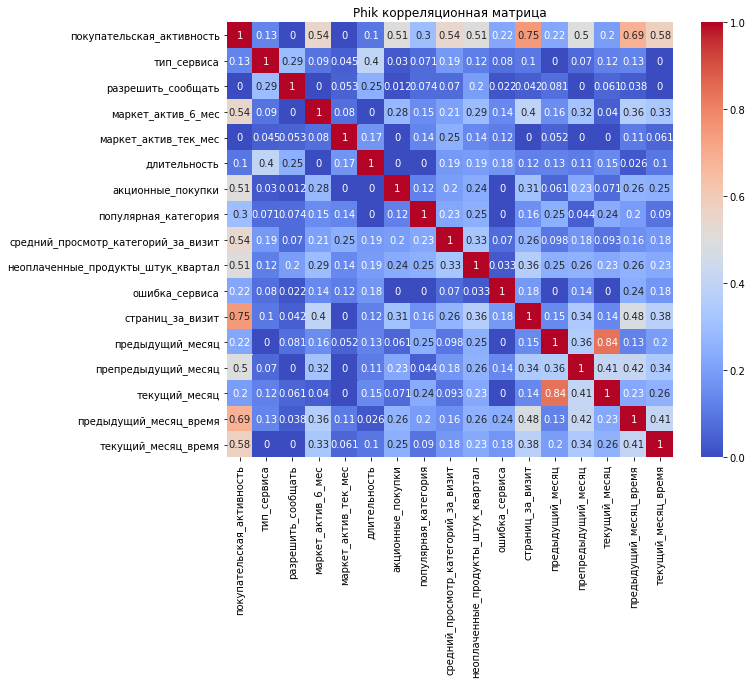

In [38]:
phik_corr = merged_df.drop(columns='id', axis=1).phik_matrix()
plt.figure(figsize=(10, 8))
sns.heatmap(phik_corr, annot=True, cmap='coolwarm', vmin=0, vmax=1)
plt.title('Phik корреляционная матрица');

<b>5.2 Итог анализа корреляции признаков</b>

<b>Есть сильная корреляция (0.84) между столбцами 'текущий_месяц' и 'предыдущий_месяц'. Если считать мультиколлинеарность от 0.90, то она отсутствует.</b>

## 6. Использование пайплайнов

<b>6.1 Создание переменных для хранения категориальных, бинарных и количественных признаков</b>

In [39]:
# Категориальные столбцы
cat_cols = ['популярная_категория', 'маркет_актив_тек_мес', 'тип_сервиса', 'разрешить_сообщать']
# Количественные столбцы
num_cols = ['маркет_актив_6_мес', 'длительность', 'акционные_покупки', 'средний_просмотр_категорий_за_визит', 
            'неоплаченные_продукты_штук_квартал', 'ошибка_сервиса', 'страниц_за_визит', 'предыдущий_месяц', 
            'препредыдущий_месяц', 'текущий_месяц', 'предыдущий_месяц_время', 'текущий_месяц_время']

<b>6.2 Создание и кодирование целевой переменной, разделение на тренировочную и тестовую выборки</b>

In [40]:
# Целевая переменная
target = 'покупательская_активность'

# Константы
RANDOM_STATE = 42
TEST_SIZE = 0.25

# Разделение данных
X = merged_df.drop(columns=[target])
y = merged_df[target]

# Деление на train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y
)

le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)  


In [41]:
le.classes_

array(['Прежний уровень', 'Снизилась'], dtype=object)

In [42]:
np.unique(y_train)

array([0, 1])

<b>6.3 Создание пайплайнов</b>

In [43]:
# Пайплайн для числовых признаков
num_pipeline_standard = Pipeline(steps=[
    ('scaler', StandardScaler())
])

num_pipeline_minmax = Pipeline(steps=[
    ('scaler', MinMaxScaler())
])

In [44]:
# Пайплайн для категориальных признаков
cat_pipeline_onehot = Pipeline(steps=[
    ('encoder', OneHotEncoder(drop='first', handle_unknown='ignore'))
])

cat_pipeline_ordinal = Pipeline(steps=[
    ('encoder', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=np.nan))
])

In [45]:
# Общий препроцессор
preprocessor = ColumnTransformer(transformers=[
    ('num', num_pipeline_standard, num_cols),
    ('cat', cat_pipeline_onehot, cat_cols)
])

In [46]:
# Общий пайплайн
pipe = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', LogisticRegression())
])

In [47]:
# Параметры для подбора
param_grid = [
    {
        'preprocessor__num': [num_pipeline_standard, num_pipeline_minmax],
        'preprocessor__cat': [cat_pipeline_onehot, cat_pipeline_ordinal],
        'model': [KNeighborsClassifier()],
        'model__n_neighbors': [3, 5, 7]
    },
    {
        'preprocessor__num': [num_pipeline_standard, num_pipeline_minmax],
        'preprocessor__cat': [cat_pipeline_onehot, cat_pipeline_ordinal],
        'model': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'model__max_depth': [3, 5, 7, 10]
    },
    {
        'preprocessor__num': [num_pipeline_standard, num_pipeline_minmax],
        'preprocessor__cat': [cat_pipeline_onehot, cat_pipeline_ordinal],
        'model': [LogisticRegression(max_iter=1000)],
        'model__C': [0.01, 0.1, 1, 10]
    },
    {
        'preprocessor__num': [num_pipeline_standard, num_pipeline_minmax],
        'preprocessor__cat': [cat_pipeline_onehot, cat_pipeline_ordinal],
        'model': [SVC(probability=True)],
        'model__C': [0.1, 1, 10],
        'model__kernel': ['linear', 'rbf']
    }
]

In [48]:
# ROC-AUC как метрика
scorer = make_scorer(roc_auc_score, needs_proba=True, multi_class='ovr')

# Поиск по сетке
grid_search = GridSearchCV(
    pipe,
    param_grid,
    cv=5,
    scoring={
        'roc_auc': scorer,
        'accuracy': 'accuracy',
        'f1_macro': 'f1_macro'
    },
    refit='roc_auc',
    n_jobs=-1,
    verbose=3
)

In [49]:
%%time

# Обучение
grid_search.fit(X_train, y_train)

# Результаты
print("Лучшая модель:", grid_search.best_estimator_)
print("Лучшие параметры:", grid_search.best_params_)
print("Лучшая оценка ROC AUC (кросс-валидация):", grid_search.best_score_)

# Оценка на тесте
best_model = grid_search.best_estimator_
y_test_proba = best_model.predict_proba(X_test)[:, 1]  # берем только вероятность класса 1
y_test_pred = best_model.predict(X_test)
test_roc_auc = roc_auc_score(y_test, y_test_proba)

print("ROC AUC на тестовой выборке:", test_roc_auc)
print("Accuracy на тесте:", accuracy_score(y_test, y_test_pred))
print("F1-score на тесте:", f1_score(y_test, y_test_pred, average='macro'))

Fitting 5 folds for each of 68 candidates, totalling 340 fits
[CV 1/5] END model=KNeighborsClassifier(), model__n_neighbors=3, preprocessor__cat=Pipeline(steps=[('encoder', OneHotEncoder(handle_unknown='ignore'))]), preprocessor__num=Pipeline(steps=[('scaler', StandardScaler())]); accuracy: (test=0.872) f1_macro: (test=0.863) roc_auc: (test=0.895) total time=   0.2s


/opt/conda/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/opt/conda/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to Tr

[CV 2/5] END model=KNeighborsClassifier(), model__n_neighbors=3, preprocessor__cat=Pipeline(steps=[('encoder', OneHotEncoder(handle_unknown='ignore'))]), preprocessor__num=Pipeline(steps=[('scaler', StandardScaler())]); accuracy: (test=0.856) f1_macro: (test=0.843) roc_auc: (test=0.856) total time=   0.3s


/opt/conda/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


[CV 3/5] END model=KNeighborsClassifier(), model__n_neighbors=3, preprocessor__cat=Pipeline(steps=[('encoder', OneHotEncoder(handle_unknown='ignore'))]), preprocessor__num=Pipeline(steps=[('scaler', StandardScaler())]); accuracy: (test=0.830) f1_macro: (test=0.819) roc_auc: (test=0.877) total time=   0.3s


/opt/conda/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


[CV 4/5] END model=KNeighborsClassifier(), model__n_neighbors=3, preprocessor__cat=Pipeline(steps=[('encoder', OneHotEncoder(handle_unknown='ignore'))]), preprocessor__num=Pipeline(steps=[('scaler', StandardScaler())]); accuracy: (test=0.851) f1_macro: (test=0.836) roc_auc: (test=0.892) total time=   0.2s


/opt/conda/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


[CV 5/5] END model=KNeighborsClassifier(), model__n_neighbors=3, preprocessor__cat=Pipeline(steps=[('encoder', OneHotEncoder(handle_unknown='ignore'))]), preprocessor__num=Pipeline(steps=[('scaler', StandardScaler())]); accuracy: (test=0.861) f1_macro: (test=0.848) roc_auc: (test=0.868) total time=   0.3s


/opt/conda/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


[CV 1/5] END model=KNeighborsClassifier(), model__n_neighbors=3, preprocessor__cat=Pipeline(steps=[('encoder', OneHotEncoder(handle_unknown='ignore'))]), preprocessor__num=Pipeline(steps=[('scaler', MinMaxScaler())]); accuracy: (test=0.826) f1_macro: (test=0.812) roc_auc: (test=0.853) total time=   0.3s


/opt/conda/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


[CV 2/5] END model=KNeighborsClassifier(), model__n_neighbors=3, preprocessor__cat=Pipeline(steps=[('encoder', OneHotEncoder(handle_unknown='ignore'))]), preprocessor__num=Pipeline(steps=[('scaler', MinMaxScaler())]); accuracy: (test=0.800) f1_macro: (test=0.787) roc_auc: (test=0.845) total time=   0.3s


/opt/conda/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


[CV 3/5] END model=KNeighborsClassifier(), model__n_neighbors=3, preprocessor__cat=Pipeline(steps=[('encoder', OneHotEncoder(handle_unknown='ignore'))]), preprocessor__num=Pipeline(steps=[('scaler', MinMaxScaler())]); accuracy: (test=0.789) f1_macro: (test=0.773) roc_auc: (test=0.792) total time=   0.3s


/opt/conda/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


[CV 4/5] END model=KNeighborsClassifier(), model__n_neighbors=3, preprocessor__cat=Pipeline(steps=[('encoder', OneHotEncoder(handle_unknown='ignore'))]), preprocessor__num=Pipeline(steps=[('scaler', MinMaxScaler())]); accuracy: (test=0.768) f1_macro: (test=0.739) roc_auc: (test=0.804) total time=   0.3s


/opt/conda/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


[CV 5/5] END model=KNeighborsClassifier(), model__n_neighbors=3, preprocessor__cat=Pipeline(steps=[('encoder', OneHotEncoder(handle_unknown='ignore'))]), preprocessor__num=Pipeline(steps=[('scaler', MinMaxScaler())]); accuracy: (test=0.784) f1_macro: (test=0.753) roc_auc: (test=0.816) total time=   0.2s


/opt/conda/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


[CV 1/5] END model=KNeighborsClassifier(), model__n_neighbors=3, preprocessor__cat=Pipeline(steps=[('encoder',
                 OrdinalEncoder(handle_unknown='use_encoded_value',
                                unknown_value=nan))]), preprocessor__num=Pipeline(steps=[('scaler', StandardScaler())]); accuracy: (test=0.867) f1_macro: (test=0.858) roc_auc: (test=0.879) total time=   0.2s


/opt/conda/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


[CV 2/5] END model=KNeighborsClassifier(), model__n_neighbors=3, preprocessor__cat=Pipeline(steps=[('encoder',
                 OrdinalEncoder(handle_unknown='use_encoded_value',
                                unknown_value=nan))]), preprocessor__num=Pipeline(steps=[('scaler', StandardScaler())]); accuracy: (test=0.862) f1_macro: (test=0.850) roc_auc: (test=0.884) total time=   0.3s


/opt/conda/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


[CV 3/5] END model=KNeighborsClassifier(), model__n_neighbors=3, preprocessor__cat=Pipeline(steps=[('encoder',
                 OrdinalEncoder(handle_unknown='use_encoded_value',
                                unknown_value=nan))]), preprocessor__num=Pipeline(steps=[('scaler', StandardScaler())]); accuracy: (test=0.861) f1_macro: (test=0.850) roc_auc: (test=0.875) total time=   0.2s


/opt/conda/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


[CV 4/5] END model=KNeighborsClassifier(), model__n_neighbors=3, preprocessor__cat=Pipeline(steps=[('encoder',
                 OrdinalEncoder(handle_unknown='use_encoded_value',
                                unknown_value=nan))]), preprocessor__num=Pipeline(steps=[('scaler', StandardScaler())]); accuracy: (test=0.840) f1_macro: (test=0.826) roc_auc: (test=0.889) total time=   0.3s


/opt/conda/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


[CV 5/5] END model=KNeighborsClassifier(), model__n_neighbors=3, preprocessor__cat=Pipeline(steps=[('encoder',
                 OrdinalEncoder(handle_unknown='use_encoded_value',
                                unknown_value=nan))]), preprocessor__num=Pipeline(steps=[('scaler', StandardScaler())]); accuracy: (test=0.866) f1_macro: (test=0.853) roc_auc: (test=0.872) total time=   0.3s


/opt/conda/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


[CV 1/5] END model=KNeighborsClassifier(), model__n_neighbors=3, preprocessor__cat=Pipeline(steps=[('encoder',
                 OrdinalEncoder(handle_unknown='use_encoded_value',
                                unknown_value=nan))]), preprocessor__num=Pipeline(steps=[('scaler', MinMaxScaler())]); accuracy: (test=0.846) f1_macro: (test=0.834) roc_auc: (test=0.862) total time=   0.2s


/opt/conda/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


[CV 2/5] END model=KNeighborsClassifier(), model__n_neighbors=3, preprocessor__cat=Pipeline(steps=[('encoder',
                 OrdinalEncoder(handle_unknown='use_encoded_value',
                                unknown_value=nan))]), preprocessor__num=Pipeline(steps=[('scaler', MinMaxScaler())]); accuracy: (test=0.805) f1_macro: (test=0.793) roc_auc: (test=0.856) total time=   0.3s


/opt/conda/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


[CV 3/5] END model=KNeighborsClassifier(), model__n_neighbors=3, preprocessor__cat=Pipeline(steps=[('encoder',
                 OrdinalEncoder(handle_unknown='use_encoded_value',
                                unknown_value=nan))]), preprocessor__num=Pipeline(steps=[('scaler', MinMaxScaler())]); accuracy: (test=0.794) f1_macro: (test=0.778) roc_auc: (test=0.800) total time=   0.2s


/opt/conda/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


[CV 4/5] END model=KNeighborsClassifier(), model__n_neighbors=3, preprocessor__cat=Pipeline(steps=[('encoder',
                 OrdinalEncoder(handle_unknown='use_encoded_value',
                                unknown_value=nan))]), preprocessor__num=Pipeline(steps=[('scaler', MinMaxScaler())]); accuracy: (test=0.784) f1_macro: (test=0.757) roc_auc: (test=0.818) total time=   0.3s


/opt/conda/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/opt/conda/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to Tr

[CV 5/5] END model=KNeighborsClassifier(), model__n_neighbors=3, preprocessor__cat=Pipeline(steps=[('encoder',
                 OrdinalEncoder(handle_unknown='use_encoded_value',
                                unknown_value=nan))]), preprocessor__num=Pipeline(steps=[('scaler', MinMaxScaler())]); accuracy: (test=0.804) f1_macro: (test=0.778) roc_auc: (test=0.827) total time=   0.4s
[CV 1/5] END model=KNeighborsClassifier(), model__n_neighbors=5, preprocessor__cat=Pipeline(steps=[('encoder', OneHotEncoder(handle_unknown='ignore'))]), preprocessor__num=Pipeline(steps=[('scaler', StandardScaler())]); accuracy: (test=0.846) f1_macro: (test=0.836) roc_auc: (test=0.888) total time=   0.2s


/opt/conda/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


[CV 2/5] END model=KNeighborsClassifier(), model__n_neighbors=5, preprocessor__cat=Pipeline(steps=[('encoder', OneHotEncoder(handle_unknown='ignore'))]), preprocessor__num=Pipeline(steps=[('scaler', StandardScaler())]); accuracy: (test=0.856) f1_macro: (test=0.841) roc_auc: (test=0.876) total time=   0.2s


/opt/conda/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


[CV 3/5] END model=KNeighborsClassifier(), model__n_neighbors=5, preprocessor__cat=Pipeline(steps=[('encoder', OneHotEncoder(handle_unknown='ignore'))]), preprocessor__num=Pipeline(steps=[('scaler', StandardScaler())]); accuracy: (test=0.845) f1_macro: (test=0.832) roc_auc: (test=0.887) total time=   0.3s


/opt/conda/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


[CV 4/5] END model=KNeighborsClassifier(), model__n_neighbors=5, preprocessor__cat=Pipeline(steps=[('encoder', OneHotEncoder(handle_unknown='ignore'))]), preprocessor__num=Pipeline(steps=[('scaler', StandardScaler())]); accuracy: (test=0.871) f1_macro: (test=0.859) roc_auc: (test=0.897) total time=   0.3s


/opt/conda/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


[CV 5/5] END model=KNeighborsClassifier(), model__n_neighbors=5, preprocessor__cat=Pipeline(steps=[('encoder', OneHotEncoder(handle_unknown='ignore'))]), preprocessor__num=Pipeline(steps=[('scaler', StandardScaler())]); accuracy: (test=0.861) f1_macro: (test=0.846) roc_auc: (test=0.869) total time=   0.3s


/opt/conda/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


[CV 1/5] END model=KNeighborsClassifier(), model__n_neighbors=5, preprocessor__cat=Pipeline(steps=[('encoder', OneHotEncoder(handle_unknown='ignore'))]), preprocessor__num=Pipeline(steps=[('scaler', MinMaxScaler())]); accuracy: (test=0.841) f1_macro: (test=0.828) roc_auc: (test=0.874) total time=   0.3s


/opt/conda/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


[CV 2/5] END model=KNeighborsClassifier(), model__n_neighbors=5, preprocessor__cat=Pipeline(steps=[('encoder', OneHotEncoder(handle_unknown='ignore'))]), preprocessor__num=Pipeline(steps=[('scaler', MinMaxScaler())]); accuracy: (test=0.795) f1_macro: (test=0.773) roc_auc: (test=0.839) total time=   0.2s


/opt/conda/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


[CV 3/5] END model=KNeighborsClassifier(), model__n_neighbors=5, preprocessor__cat=Pipeline(steps=[('encoder', OneHotEncoder(handle_unknown='ignore'))]), preprocessor__num=Pipeline(steps=[('scaler', MinMaxScaler())]); accuracy: (test=0.768) f1_macro: (test=0.739) roc_auc: (test=0.825) total time=   0.4s


/opt/conda/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


[CV 4/5] END model=KNeighborsClassifier(), model__n_neighbors=5, preprocessor__cat=Pipeline(steps=[('encoder', OneHotEncoder(handle_unknown='ignore'))]), preprocessor__num=Pipeline(steps=[('scaler', MinMaxScaler())]); accuracy: (test=0.768) f1_macro: (test=0.734) roc_auc: (test=0.792) total time=   0.3s
[CV 5/5] END model=KNeighborsClassifier(), model__n_neighbors=5, preprocessor__cat=Pipeline(steps=[('encoder', OneHotEncoder(handle_unknown='ignore'))]), preprocessor__num=Pipeline(steps=[('scaler', MinMaxScaler())]); accuracy: (test=0.773) f1_macro: (test=0.735) roc_auc: (test=0.839) total time=   0.2s


/opt/conda/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/opt/conda/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to Tr

[CV 1/5] END model=KNeighborsClassifier(), model__n_neighbors=5, preprocessor__cat=Pipeline(steps=[('encoder',
                 OrdinalEncoder(handle_unknown='use_encoded_value',
                                unknown_value=nan))]), preprocessor__num=Pipeline(steps=[('scaler', StandardScaler())]); accuracy: (test=0.862) f1_macro: (test=0.851) roc_auc: (test=0.895) total time=   0.3s


/opt/conda/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


[CV 2/5] END model=KNeighborsClassifier(), model__n_neighbors=5, preprocessor__cat=Pipeline(steps=[('encoder',
                 OrdinalEncoder(handle_unknown='use_encoded_value',
                                unknown_value=nan))]), preprocessor__num=Pipeline(steps=[('scaler', StandardScaler())]); accuracy: (test=0.872) f1_macro: (test=0.859) roc_auc: (test=0.894) total time=   0.3s


/opt/conda/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


[CV 3/5] END model=KNeighborsClassifier(), model__n_neighbors=5, preprocessor__cat=Pipeline(steps=[('encoder',
                 OrdinalEncoder(handle_unknown='use_encoded_value',
                                unknown_value=nan))]), preprocessor__num=Pipeline(steps=[('scaler', StandardScaler())]); accuracy: (test=0.876) f1_macro: (test=0.867) roc_auc: (test=0.884) total time=   0.3s


/opt/conda/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


[CV 4/5] END model=KNeighborsClassifier(), model__n_neighbors=5, preprocessor__cat=Pipeline(steps=[('encoder',
                 OrdinalEncoder(handle_unknown='use_encoded_value',
                                unknown_value=nan))]), preprocessor__num=Pipeline(steps=[('scaler', StandardScaler())]); accuracy: (test=0.845) f1_macro: (test=0.830) roc_auc: (test=0.891) total time=   0.2s


/opt/conda/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


[CV 5/5] END model=KNeighborsClassifier(), model__n_neighbors=5, preprocessor__cat=Pipeline(steps=[('encoder',
                 OrdinalEncoder(handle_unknown='use_encoded_value',
                                unknown_value=nan))]), preprocessor__num=Pipeline(steps=[('scaler', StandardScaler())]); accuracy: (test=0.871) f1_macro: (test=0.855) roc_auc: (test=0.863) total time=   0.2s


/opt/conda/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


[CV 1/5] END model=KNeighborsClassifier(), model__n_neighbors=5, preprocessor__cat=Pipeline(steps=[('encoder',
                 OrdinalEncoder(handle_unknown='use_encoded_value',
                                unknown_value=nan))]), preprocessor__num=Pipeline(steps=[('scaler', MinMaxScaler())]); accuracy: (test=0.851) f1_macro: (test=0.837) roc_auc: (test=0.878) total time=   0.2s


/opt/conda/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


[CV 2/5] END model=KNeighborsClassifier(), model__n_neighbors=5, preprocessor__cat=Pipeline(steps=[('encoder',
                 OrdinalEncoder(handle_unknown='use_encoded_value',
                                unknown_value=nan))]), preprocessor__num=Pipeline(steps=[('scaler', MinMaxScaler())]); accuracy: (test=0.805) f1_macro: (test=0.784) roc_auc: (test=0.848) total time=   0.3s


/opt/conda/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


[CV 3/5] END model=KNeighborsClassifier(), model__n_neighbors=5, preprocessor__cat=Pipeline(steps=[('encoder',
                 OrdinalEncoder(handle_unknown='use_encoded_value',
                                unknown_value=nan))]), preprocessor__num=Pipeline(steps=[('scaler', MinMaxScaler())]); accuracy: (test=0.773) f1_macro: (test=0.747) roc_auc: (test=0.840) total time=   0.2s


/opt/conda/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


[CV 4/5] END model=KNeighborsClassifier(), model__n_neighbors=5, preprocessor__cat=Pipeline(steps=[('encoder',
                 OrdinalEncoder(handle_unknown='use_encoded_value',
                                unknown_value=nan))]), preprocessor__num=Pipeline(steps=[('scaler', MinMaxScaler())]); accuracy: (test=0.789) f1_macro: (test=0.760) roc_auc: (test=0.815) total time=   0.3s


/opt/conda/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


[CV 5/5] END model=KNeighborsClassifier(), model__n_neighbors=5, preprocessor__cat=Pipeline(steps=[('encoder',
                 OrdinalEncoder(handle_unknown='use_encoded_value',
                                unknown_value=nan))]), preprocessor__num=Pipeline(steps=[('scaler', MinMaxScaler())]); accuracy: (test=0.789) f1_macro: (test=0.756) roc_auc: (test=0.845) total time=   0.3s


/opt/conda/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


[CV 1/5] END model=KNeighborsClassifier(), model__n_neighbors=7, preprocessor__cat=Pipeline(steps=[('encoder', OneHotEncoder(handle_unknown='ignore'))]), preprocessor__num=Pipeline(steps=[('scaler', StandardScaler())]); accuracy: (test=0.862) f1_macro: (test=0.851) roc_auc: (test=0.898) total time=   0.3s


/opt/conda/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


[CV 2/5] END model=KNeighborsClassifier(), model__n_neighbors=7, preprocessor__cat=Pipeline(steps=[('encoder', OneHotEncoder(handle_unknown='ignore'))]), preprocessor__num=Pipeline(steps=[('scaler', StandardScaler())]); accuracy: (test=0.872) f1_macro: (test=0.858) roc_auc: (test=0.876) total time=   0.3s


/opt/conda/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


[CV 3/5] END model=KNeighborsClassifier(), model__n_neighbors=7, preprocessor__cat=Pipeline(steps=[('encoder', OneHotEncoder(handle_unknown='ignore'))]), preprocessor__num=Pipeline(steps=[('scaler', StandardScaler())]); accuracy: (test=0.840) f1_macro: (test=0.827) roc_auc: (test=0.889) total time=   0.3s


/opt/conda/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


[CV 4/5] END model=KNeighborsClassifier(), model__n_neighbors=7, preprocessor__cat=Pipeline(steps=[('encoder', OneHotEncoder(handle_unknown='ignore'))]), preprocessor__num=Pipeline(steps=[('scaler', StandardScaler())]); accuracy: (test=0.876) f1_macro: (test=0.862) roc_auc: (test=0.901) total time=   0.4s


/opt/conda/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


[CV 5/5] END model=KNeighborsClassifier(), model__n_neighbors=7, preprocessor__cat=Pipeline(steps=[('encoder', OneHotEncoder(handle_unknown='ignore'))]), preprocessor__num=Pipeline(steps=[('scaler', StandardScaler())]); accuracy: (test=0.851) f1_macro: (test=0.832) roc_auc: (test=0.876) total time=   0.3s


/opt/conda/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


[CV 1/5] END model=KNeighborsClassifier(), model__n_neighbors=7, preprocessor__cat=Pipeline(steps=[('encoder', OneHotEncoder(handle_unknown='ignore'))]), preprocessor__num=Pipeline(steps=[('scaler', MinMaxScaler())]); accuracy: (test=0.841) f1_macro: (test=0.823) roc_auc: (test=0.888) total time=   0.3s


/opt/conda/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


[CV 2/5] END model=KNeighborsClassifier(), model__n_neighbors=7, preprocessor__cat=Pipeline(steps=[('encoder', OneHotEncoder(handle_unknown='ignore'))]), preprocessor__num=Pipeline(steps=[('scaler', MinMaxScaler())]); accuracy: (test=0.779) f1_macro: (test=0.751) roc_auc: (test=0.841) total time=   0.3s


/opt/conda/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


[CV 3/5] END model=KNeighborsClassifier(), model__n_neighbors=7, preprocessor__cat=Pipeline(steps=[('encoder', OneHotEncoder(handle_unknown='ignore'))]), preprocessor__num=Pipeline(steps=[('scaler', MinMaxScaler())]); accuracy: (test=0.773) f1_macro: (test=0.739) roc_auc: (test=0.818) total time=   0.3s


/opt/conda/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


[CV 4/5] END model=KNeighborsClassifier(), model__n_neighbors=7, preprocessor__cat=Pipeline(steps=[('encoder', OneHotEncoder(handle_unknown='ignore'))]), preprocessor__num=Pipeline(steps=[('scaler', MinMaxScaler())]); accuracy: (test=0.758) f1_macro: (test=0.731) roc_auc: (test=0.799) total time=   0.3s


/opt/conda/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


[CV 5/5] END model=KNeighborsClassifier(), model__n_neighbors=7, preprocessor__cat=Pipeline(steps=[('encoder', OneHotEncoder(handle_unknown='ignore'))]), preprocessor__num=Pipeline(steps=[('scaler', MinMaxScaler())]); accuracy: (test=0.789) f1_macro: (test=0.754) roc_auc: (test=0.841) total time=   0.3s


/opt/conda/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


[CV 1/5] END model=KNeighborsClassifier(), model__n_neighbors=7, preprocessor__cat=Pipeline(steps=[('encoder',
                 OrdinalEncoder(handle_unknown='use_encoded_value',
                                unknown_value=nan))]), preprocessor__num=Pipeline(steps=[('scaler', StandardScaler())]); accuracy: (test=0.872) f1_macro: (test=0.862) roc_auc: (test=0.894) total time=   0.2s


/opt/conda/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


[CV 2/5] END model=KNeighborsClassifier(), model__n_neighbors=7, preprocessor__cat=Pipeline(steps=[('encoder',
                 OrdinalEncoder(handle_unknown='use_encoded_value',
                                unknown_value=nan))]), preprocessor__num=Pipeline(steps=[('scaler', StandardScaler())]); accuracy: (test=0.877) f1_macro: (test=0.865) roc_auc: (test=0.892) total time=   0.2s


/opt/conda/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


[CV 3/5] END model=KNeighborsClassifier(), model__n_neighbors=7, preprocessor__cat=Pipeline(steps=[('encoder',
                 OrdinalEncoder(handle_unknown='use_encoded_value',
                                unknown_value=nan))]), preprocessor__num=Pipeline(steps=[('scaler', StandardScaler())]); accuracy: (test=0.892) f1_macro: (test=0.882) roc_auc: (test=0.898) total time=   0.3s


/opt/conda/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


[CV 4/5] END model=KNeighborsClassifier(), model__n_neighbors=7, preprocessor__cat=Pipeline(steps=[('encoder',
                 OrdinalEncoder(handle_unknown='use_encoded_value',
                                unknown_value=nan))]), preprocessor__num=Pipeline(steps=[('scaler', StandardScaler())]); accuracy: (test=0.840) f1_macro: (test=0.824) roc_auc: (test=0.884) total time=   0.2s


/opt/conda/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


[CV 5/5] END model=KNeighborsClassifier(), model__n_neighbors=7, preprocessor__cat=Pipeline(steps=[('encoder',
                 OrdinalEncoder(handle_unknown='use_encoded_value',
                                unknown_value=nan))]), preprocessor__num=Pipeline(steps=[('scaler', StandardScaler())]); accuracy: (test=0.871) f1_macro: (test=0.855) roc_auc: (test=0.876) total time=   0.3s


/opt/conda/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


[CV 1/5] END model=KNeighborsClassifier(), model__n_neighbors=7, preprocessor__cat=Pipeline(steps=[('encoder',
                 OrdinalEncoder(handle_unknown='use_encoded_value',
                                unknown_value=nan))]), preprocessor__num=Pipeline(steps=[('scaler', MinMaxScaler())]); accuracy: (test=0.851) f1_macro: (test=0.835) roc_auc: (test=0.889) total time=   0.4s


/opt/conda/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


[CV 2/5] END model=KNeighborsClassifier(), model__n_neighbors=7, preprocessor__cat=Pipeline(steps=[('encoder',
                 OrdinalEncoder(handle_unknown='use_encoded_value',
                                unknown_value=nan))]), preprocessor__num=Pipeline(steps=[('scaler', MinMaxScaler())]); accuracy: (test=0.795) f1_macro: (test=0.769) roc_auc: (test=0.852) total time=   0.3s


/opt/conda/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


[CV 3/5] END model=KNeighborsClassifier(), model__n_neighbors=7, preprocessor__cat=Pipeline(steps=[('encoder',
                 OrdinalEncoder(handle_unknown='use_encoded_value',
                                unknown_value=nan))]), preprocessor__num=Pipeline(steps=[('scaler', MinMaxScaler())]); accuracy: (test=0.789) f1_macro: (test=0.760) roc_auc: (test=0.841) total time=   0.2s


/opt/conda/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


[CV 4/5] END model=KNeighborsClassifier(), model__n_neighbors=7, preprocessor__cat=Pipeline(steps=[('encoder',
                 OrdinalEncoder(handle_unknown='use_encoded_value',
                                unknown_value=nan))]), preprocessor__num=Pipeline(steps=[('scaler', MinMaxScaler())]); accuracy: (test=0.804) f1_macro: (test=0.780) roc_auc: (test=0.825) total time=   0.3s


/opt/conda/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


[CV 5/5] END model=KNeighborsClassifier(), model__n_neighbors=7, preprocessor__cat=Pipeline(steps=[('encoder',
                 OrdinalEncoder(handle_unknown='use_encoded_value',
                                unknown_value=nan))]), preprocessor__num=Pipeline(steps=[('scaler', MinMaxScaler())]); accuracy: (test=0.784) f1_macro: (test=0.747) roc_auc: (test=0.844) total time=   0.3s
[CV 1/5] END model=DecisionTreeClassifier(random_state=42), model__max_depth=3, preprocessor__cat=Pipeline(steps=[('encoder', OneHotEncoder(handle_unknown='ignore'))]), preprocessor__num=Pipeline(steps=[('scaler', StandardScaler())]); accuracy: (test=0.826) f1_macro: (test=0.802) roc_auc: (test=0.803) total time=   0.1s
[CV 2/5] END model=DecisionTreeClassifier(random_state=42), model__max_depth=3, preprocessor__cat=Pipeline(steps=[('encoder', OneHotEncoder(handle_unknown='ignore'))]), preprocessor__num=Pipeline(steps=[('scaler', StandardScaler())]); accuracy: (test=0.862) f1_macro: (test=0.844) roc_auc: (te

In [50]:
grid_search.cv_results_

{'mean_fit_time': array([0.08362589, 0.0798852 , 0.1160213 , 0.08079309, 0.08242221,
        0.09664097, 0.08018684, 0.09952722, 0.10093093, 0.10047317,
        0.04820228, 0.11734171, 0.03261662, 0.0128571 , 0.01183505,
        0.01162367, 0.01393809, 0.01266775, 0.01312675, 0.01369219,
        0.01439271, 0.01400366, 0.01365767, 0.01397972, 0.01493969,
        0.01434245, 0.01544719, 0.01436992, 0.02330446, 0.01672664,
        0.08538747, 0.08459454, 0.07269688, 0.1548521 , 0.10511351,
        0.21431603, 0.12059722, 0.31468062, 0.11882443, 0.40296822,
        0.19850125, 0.3596149 , 0.1390233 , 0.39869184, 0.08163576,
        0.06908712, 0.05218306, 0.0583281 , 0.10985107, 0.13285027,
        0.09000568, 0.10906062, 0.10718188, 0.06766362, 0.10042748,
        0.06188908, 0.09839497, 0.10027275, 0.08167186, 0.13024635,
        0.50963645, 0.13092537, 0.43752766, 0.13725257, 0.11799588,
        0.11492724, 0.09669757, 0.08621788]),
 'std_fit_time': array([3.66240984e-02, 3.49995281e-0

<b>6.4 Итог создания модели</b>

<b>После перебора разных моделей и их параметров метрика ROC-AUC лучшей модели (модель SVC с параметром C=1 и кодировщиком OrdinalEncoder) выдала хороший результат на тестовой выборке - 0.918.</b>

## 7. Анализ важности признаков

<b>7.1 Построение графика важности признаков</b>

<b>Чтобы не затягивать процесс построения графика, для этого отберем 100 случайных строк. Это никак не отразится на качестве анализа</b>

In [51]:
# Функция для дальнейшей работы (в старых версиях sklearn готовой функции нет)
def get_feature_names_old(column_transformer):
    output_features = []

    for name, transformer, columns in column_transformer.transformers_:
        if name == 'remainder':
            continue

        if isinstance(transformer, Pipeline):
            # Получаем последний шаг пайплайна
            transformer = transformer.steps[-1][1]

        if hasattr(transformer, 'categories_'):
            cats = transformer.categories_
            new_features = []
            for col, cats_per_col in zip(columns, cats):
                new_features.extend([f"{col}_{cat}" for cat in cats_per_col])
            output_features.extend(new_features)ыфывфыв
        else:
            output_features.extend(columns)

    return output_features

feature_names = get_feature_names_old(best_model.named_steps['preprocessor'])
print(feature_names)

['маркет_актив_6_мес', 'длительность', 'акционные_покупки', 'средний_просмотр_категорий_за_визит', 'неоплаченные_продукты_штук_квартал', 'ошибка_сервиса', 'страниц_за_визит', 'предыдущий_месяц', 'препредыдущий_месяц', 'текущий_месяц', 'предыдущий_месяц_время', 'текущий_месяц_время', 'популярная_категория_Домашний текстиль', 'популярная_категория_Косметика и аксесуары', 'популярная_категория_Кухонная посуда', 'популярная_категория_Мелкая бытовая техника и электроника', 'популярная_категория_Техника для красоты и здоровья', 'популярная_категория_Товары для детей', 'маркет_актив_тек_мес_3', 'маркет_актив_тек_мес_4', 'маркет_актив_тек_мес_5', 'тип_сервиса_премиум', 'тип_сервиса_стандарт', 'разрешить_сообщать_да', 'разрешить_сообщать_нет']


In [52]:
X_test_transformed = best_model.named_steps['preprocessor'].transform(X_test)
background = shap.sample(X_test_transformed, 100, random_state=42)

explainer = shap.KernelExplainer(best_model.named_steps['model'].decision_function, background)
shap_values = explainer.shap_values(X_test_transformed[:100])

feature_names = num_cols + cat_cols

if isinstance(shap_values, list):
    shap_values = shap_values[0] 

shap.summary_plot(shap_values, features=X_test_transformed[:100], feature_names=feature_names)

  0%|          | 0/100 [00:00<?, ?it/s]

KeyboardInterrupt: 

<b>7.2 Вывод по анализу признаков</b>

<b>'Страница за визит' - самый важный признак. Чем больше значение в этом столбце (красные точки), тем ниже риск ухода (уход смещается влево, SHAP меньше нуля). 'предыдущий_месяц_время' и 'текущий_месяц_время' тоже являются важными признаками. Чем больше времени клиент проводил на сайте (красный), тем вероятность ухода уменьшается. Столбец 'Средний_просмотр_категорий_за_визит' аналогично: малое число просмотренных категорий = потенциальный риск снижения активности.
Интересно, что высокие значения 'Акционные_покупки' (красный) увеличивают риск ухода.
Возможно, клиенты "охотятся за скидками", а после, их активность снижается. Остальные столбцы влияют на снижение активности умеренно, за исключением 'Тип сервиса' и 'Разрешить сообщать'. Эти два столбца практически никак не влияют на активность пользователей</b>

## 8. Сегментация покупателей

<b>8.1 Сегментация покупателей на основе предсказаний лучшей модели</b>

<b>Добавим предсказанние вероятностей и истинных классов к тестовым данным</b>

In [53]:
index_target = list(le.classes_).index('Снизилась')

proba_target = best_model.predict_proba(X_test)[:, index_target]

In [54]:
X_test['proba'] = proba_s
X_test['true_class'] = le.inverse_transform(y_test)

/tmp/ipykernel_118/13945036.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['proba'] = proba_s
/tmp/ipykernel_118/13945036.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['true_class'] = le.inverse_transform(y_test)


In [55]:
le.classes_

array(['Прежний уровень', 'Снизилась'], dtype=object)

<b>Объединим с таблицей прибыли и разделим на сегменты. Будет всего 3 группы риска снижения активности - низкий, средний и высокий</b>

In [ ]:
# Объединяем с прибылью
merged_df = X_test.merge(money_df, on='id', how='left')

# Создаем группы риска по вероятности
merged_df['risk_group'] = pd.cut(
    merged_df['proba'],
    bins=[0, 0.4, 0.7, 1.0],
    labels=['Low Risk', 'Medium Risk', 'High Risk']
)

<b>Соберем статистики по группам</b>

In [ ]:
# Анализ групп по статистикам
group_summary = merged_df.groupby('risk_group').agg({
    'proba': ['mean', 'median'],
    'Прибыль': ['mean', 'median', 'sum'],
    'Длительность': 'mean',
    'Акционные_покупки': 'mean',
    'Разрешить сообщать': lambda x: x.value_counts(normalize=True).get('Да', 0),
    'Ошибка_сервиса': 'mean',
    'Средний_просмотр_категорий_за_визит': 'mean'
}).reset_index()

<b>Визуализируем то что получилось</b>

In [ ]:
plt.figure(figsize=(10,6))
sns.boxplot(x='risk_group', y='Прибыль', data=merged_df)
plt.title('Распределение прибыли по группам риска')
plt.xlabel('Группа риска')
plt.ylabel('Прибыль')
plt.show();

plt.figure(figsize=(10,6))
sns.countplot(x='risk_group', hue='true_class', data=merged_df)
plt.title('Распределение целевого класса по группам риска')
plt.xlabel('Группа риска')
plt.ylabel('Количество клиентов')
plt.show();

<b>8.2 Итоговый вывод по сегментам</b>

<b>На графике распределения вероятностей видно, что в группе High Risk преобладают клиенты, которые реально снизили свою активность. Предложения по работе с сегментом High Risk:  <br>
1. Предложить геймификацию: бонусы за активность (например, просмотр категорий, отзыв);
2. Проверить стабильность сервиса для этой группы - SHAP показывает влияние ошибок;
3. Поддерживать интерес через "эксклюзивные предложения", вместо постоянных скидок
</b>

## 9. Вывод

<b>
1. В таблице market_file_df были обнаружены неявные дубликаты, причиной которых стала опечатка в столбце 'Тип сервиса'. Опечатка была исправлена, что позволило устранить дублирование записей.<br>

В таблице market_time_df также обнаружена опечатка в столбце 'Период'. Хотя она не критична (не влияла на объединение таблиц), для чистоты данных ошибка была устранена.<br>

Пропусков и явных дубликатов в данных не обнаружено.<br>

Типы данных приведены в соответствие с содержимым столбцов.<br>
    
2. В таблице market_money_df удалены выбросы, что позволило улучшить качество данных и избежать искажений в модели.<br>

После удаления выбросов из сводной таблицы удалены и соответствующие пустые строки.<br>

Размерность датафрейма изменилась незначительно: из выборки исключены только 4 пользователя.<br>

3. Целевая переменная 'Покупательская активность' имеет дисбаланс классов (доля клиентов со сниженной активностью заметно ниже).<br>

Поэтому для оценки модели была выбрана метрика ROC-AUC, которая устойчива к дисбалансу, в отличие от метрики accuracy, а также предсказывает вероятности классов.<br>

4. Обнаружена сильная корреляция (0.84) между переменными 'текущий_месяц' и 'предыдущий_месяц'.<br>

Мультиколлинеарность отсутствует, что позволяет оставить все числовые признаки в модели.<br>

5. В процессе подбора моделей лучшей оказалась Support Vector Classifier (SVC) с параметром C=1, кодировщиком категориальных признаков - OrdinalEncoder и кодировщиком числовых признаков - StandardScaler.<br>

Качество предсказания на тестовой выборке по метрике ROC-AUC составило 0.918 — это высокий показатель, подтверждающий надёжность модели.<br>

6. Наибольшее влияние на вероятность снижения активности оказали следующие признаки:<br>

'Страниц_за_визит' - чем больше страниц просматривает клиент, тем ниже риск снижения активности.<br>

'предыдущий_месяц_время' и 'текущий_месяц_время' - длительное пребывание на сайте снижает вероятность ухода.<br>

'Средний_просмотр_категорий_за_визит' - низкие значения связаны с риском потери интереса.<br>

'Акционные_покупки' - высокие значения увеличивают риск снижения активности, что может указывать на «охотников за акциями», которые теряют интерес после использования скидок.<br>

Факторы 'Тип сервиса' и 'Разрешить сообщать' оказались наименее значимыми.<br>

7. Клиенты успешно разделены на три группы риска по вероятности снижения активности:<br>

Low Risk (до 0.4) - стабильные клиенты;<br>

Medium Risk (0.4–0.7) - зона неопределённости;<br>

High Risk (выше 0.7) - высоковероятный отток.<br>

Наблюдения:<br><br>
В группе High Risk действительно преобладают клиенты, которые фактически снизили свою активность.<br>

В группе Low Risk большинство клиентов сохранили прежний уровень активности.<br>
<br>
8. Рекомендации для группы High Risk: <br><br>
Геймификация взаимодействия:<br>

Введение бонусов или накопительных программ за активность (например, за просмотр категорий или отзывы).<br>

Контроль качества сервиса:<br>

Провести аудит стабильности сервиса для клиентов High Risk (SHAP показал важность признака 'Ошибка_сервиса').<br>

Персонализированные предложения:<br>

Снизить долю универсальных скидок.<br>

Разрабатывать индивидуальные офферы (например, персональные подборки или уникальные предложения вне акций).<br>

Пересмотреть коммуникации:<br>

Для этой группы оптимизировать рассылки: предложить новые категории товаров или тематики.<br>
</b>